## Tasks:
- [ ] Код должен выполняться без ошибок от начала до конца
- [x] Должен быть указана оценка R2 для задачи регрессии
- [ ] Должны быть приведены важность признаков
- [ ] Код-ревью и окончательный отбор
- [ ] Добавить файл requirements.txt содержащий все нужные библиотеки для запуска проекта.
- [ ] Позаботьтесь о чистоте кода. Перед отправкой решения свежим взглядом окинуть свой код и убедиться, что в коде используются понятные названия, нет неиспользуемого/закомментированного кода, дубликатов.
- [x] Необходимо прислать ссылку на GitHub или приложить ссылку на архив с решением

<!-- Идеи:
- Собрать ситэйшны у пэйперов и построить из них граф. Посчитать эмбеддинги из этого графа (например, при помощи Verse) и добавить их в простенькую нейронку вместе с мета фичами (журнал, кол-во странииц, и тд) -->

In [1]:
# download libraries from requirements.txt
!pip install -r requirements.txt

In [2]:
# importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import Counter
from pathlib import Path
import requests
import gzip
import json
import os
import re

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import xgboost as xgb


from scholarmetrics import hindex, gindex
import scipy.stats as ss

## 1. Parsing Data

In [3]:
# link to the manifest
manifest = "https://s3-us-west-2.amazonaws.com/ai2-s2-research-public/open-corpus/2021-03-01/manifest.txt"

response = requests.get(manifest)
# according to the task we select only 30 files
files = response.text.split('\n')[:30]

In [4]:
folder_to_save = "data"

folder = Path(folder_to_save)
# if folder does not exist then create it
if not folder.is_dir():
    folder.mkdir(parents=True)

In [5]:
# link to the corpus with files
corpus_link = "https://s3-us-west-2.amazonaws.com/ai2-s2-research-public/open-corpus/2021-03-01/"

# dataframe to store all article information
article_info = pd.DataFrame()

for file in files:
    # make a request to the s3 service
    response = requests.get(corpus_link + file)
    # path to the file
    path = os.path.join(folder_to_save, file)
    # write contents of the reuqest to the file
    with open(path, 'wb+') as f:
        f.write(response.content)
        
    # unzip this file
    with gzip.open(path, 'rb') as f:    
        file_data = f.read()        

    # make dataframe out of the file    
    df = pd.read_json(file_data, orient='records', lines=True)
    # join new dataframe with article_info dataframe 
    article_info = pd.concat([article_info, df])
    # delete temporary dataframe
    del df  
        
    print('Finished downloading one file')

Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file
Finished downloading one file


In [6]:
# set index 'id' and display few rows 
article_info.set_index('id', inplace=True)
article_info.head(3)

,title,paperAbstract,authors,inCitations,outCitations,year,s2Url,sources,pdfUrls,venue,journalName,journalVolume,journalPages,doi,doiUrl,pmid,fieldsOfStudy,magId,s2PdfUrl,entities
id,,,,,,,,,,,,,,,,,,,,
33b237709dbd53953a750355115b57ccb6690da1,USING PHOTO IMAGES TO DETERMINE THE GEOMETRIC ...,,"[{'name': 'E Popov', 'ids': ['144112922']}, {...",[],[],2019.0,https://semanticscholar.org/paper/33b237709dbd...,[],[],,,19,45-54,10.14529/build190307,https://doi.org/10.14529/build190307,,[Computer Science],3000193832,,[]
062e9c7579adc73129e1198671d05905f07d4ab5,Clinical or Industrial Pharmacy? Case Studies ...,Automated medication dispensing systems for ho...,"[{'name': 'J Novek', 'ids': ['47586327']}]","[799bde07f3e9dc7f39d30ae9e1ac29cda9cd5a5c, 59a...","[a402dac75befed8c389fe00a3b6eed7ee8da87e1, 7d9...",1998.0,https://semanticscholar.org/paper/062e9c7579ad...,[Medline],[],International journal of health services : pla...,International Journal of Health Services,28,445 - 465,10.2190/W2BT-FGXQ-QL0G-YNL9,https://doi.org/10.2190/W2BT-FGXQ-QL0G-YNL9,9711475,[Medicine],1988383910,,[]
771723e7e2d9ed97d09442086553b726f0dd6657,Noncoronary and coronary atherothrombotic plaq...,"In the future, the use of imaging methods to q...","[{'name': 'Zahi A Fayad', 'ids': ['1886137']}]","[ba2cbbac306fa374c7c07da398e31a52c5680a58, 494...","[3109764f646de80e096609f86b5e4bf19320c81c, aea...",2002.0,https://semanticscholar.org/paper/771723e7e2d9...,[Medline],[],Neuroimaging clinics of North America,Neuroimaging clinics of North America,12 3,\n 461-71\n,10.1016/S1052-5149(02)00023-0,https://doi.org/10.1016/S1052-5149%2802%2900023-0,12486833,[Medicine],1983175018,,[]


## 2. Data Pre-processing

in this section we will discover our features and manipulate column data to get desirable features for machine learning stage.

In [7]:
# our dataset is huge
# we have about a 9.5k rows with 20 features
article_info.shape

(954657, 20)

let's look at our dataset
we have a lot of noninteger columns, some are lists, some are urls
we need to prepare this data to pass it to the ML model 

In [8]:
article_info.head(5)

,title,paperAbstract,authors,inCitations,outCitations,year,s2Url,sources,pdfUrls,venue,journalName,journalVolume,journalPages,doi,doiUrl,pmid,fieldsOfStudy,magId,s2PdfUrl,entities
id,,,,,,,,,,,,,,,,,,,,
33b237709dbd53953a750355115b57ccb6690da1,USING PHOTO IMAGES TO DETERMINE THE GEOMETRIC ...,,"[{'name': 'E Popov', 'ids': ['144112922']}, {...",[],[],2019.0,https://semanticscholar.org/paper/33b237709dbd...,[],[],,,19,45-54,10.14529/build190307,https://doi.org/10.14529/build190307,,[Computer Science],3000193832,,[]
062e9c7579adc73129e1198671d05905f07d4ab5,Clinical or Industrial Pharmacy? Case Studies ...,Automated medication dispensing systems for ho...,"[{'name': 'J Novek', 'ids': ['47586327']}]","[799bde07f3e9dc7f39d30ae9e1ac29cda9cd5a5c, 59a...","[a402dac75befed8c389fe00a3b6eed7ee8da87e1, 7d9...",1998.0,https://semanticscholar.org/paper/062e9c7579ad...,[Medline],[],International journal of health services : pla...,International Journal of Health Services,28,445 - 465,10.2190/W2BT-FGXQ-QL0G-YNL9,https://doi.org/10.2190/W2BT-FGXQ-QL0G-YNL9,9711475,[Medicine],1988383910,,[]
771723e7e2d9ed97d09442086553b726f0dd6657,Noncoronary and coronary atherothrombotic plaq...,"In the future, the use of imaging methods to q...","[{'name': 'Zahi A Fayad', 'ids': ['1886137']}]","[ba2cbbac306fa374c7c07da398e31a52c5680a58, 494...","[3109764f646de80e096609f86b5e4bf19320c81c, aea...",2002.0,https://semanticscholar.org/paper/771723e7e2d9...,[Medline],[],Neuroimaging clinics of North America,Neuroimaging clinics of North America,12 3,\n 461-71\n,10.1016/S1052-5149(02)00023-0,https://doi.org/10.1016/S1052-5149%2802%2900023-0,12486833,[Medicine],1983175018,,[]
263f70167ba7def67a2843ffc30c80a0b9b3f617,국어 명사구 접속의 연구,,"[{'name': '최재희', 'ids': ['115087709']}]",[],[],1985.0,https://semanticscholar.org/paper/263f70167ba7...,[],[],,,,,,,,[],2291560164,,[]
9ea1148fa657103879ef7ed9a5b716be48ee13a4,Who'll Take My Place : When I'm Gone,,"[{'name': 'Billy Fazioli', 'ids': ['146257415...",[],[],2018.0,https://semanticscholar.org/paper/9ea1148fa657...,[],[https://digitalcommons.library.umaine.edu/cgi...,,,,,,,,[Art],1489188979,,[]


### 2.1 inCitations or outCitations?

Which of those two features refer to the papers which have cited the paper?

let's find out

In [9]:
article_info.loc['d2ffe43c1eb26d971c0103bee923c719b2866b65'].title

'Smyd3-associated regulatory pathways in cancer.'

In [10]:
len(article_info.loc['d2ffe43c1eb26d971c0103bee923c719b2866b65'].outCitations)

177

In [11]:
len(article_info.loc['d2ffe43c1eb26d971c0103bee923c719b2866b65'].inCitations)

22

I have found this paper and looked to the references. According to the screenshot below, we can see that paper with id d2ffe43c1eb26d971c0103bee923c719b2866b65 has `177` citations, thus `outCitations` refer to the papers which have been cited in the paper. 

But, we need `inCitations` needed to count number of papers `cited our paper`

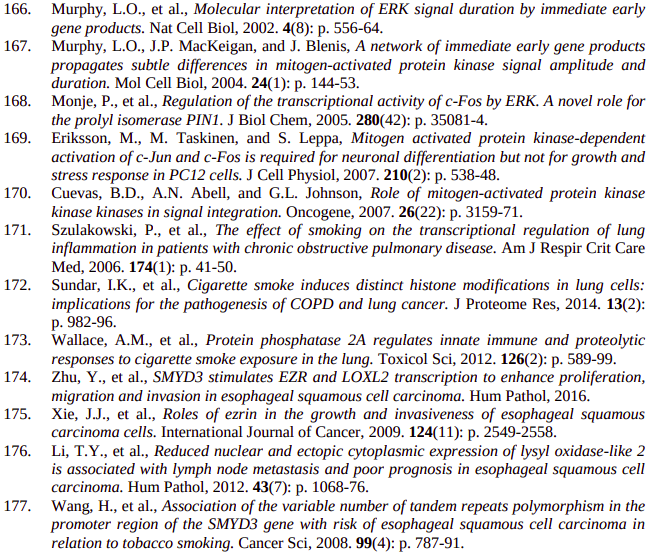


### 2.2 Moving inCitations to another dataframe

We will need to use citations information for building our model, this column will be our target variable, and we will do some operations with this column

Thus we will take it out to another dataframe

In [12]:
inCitations = article_info.inCitations
inCitations.head(3)

id
33b237709dbd53953a750355115b57ccb6690da1                                                   []
062e9c7579adc73129e1198671d05905f07d4ab5    [799bde07f3e9dc7f39d30ae9e1ac29cda9cd5a5c, 59a...
771723e7e2d9ed97d09442086553b726f0dd6657    [ba2cbbac306fa374c7c07da398e31a52c5680a58, 494...
Name: inCitations, dtype: object

In [13]:
# drop redundant column
article_info.drop('inCitations', axis=1, inplace=True)

In [26]:
inCitations

id
33b237709dbd53953a750355115b57ccb6690da1                                                   []
062e9c7579adc73129e1198671d05905f07d4ab5    [799bde07f3e9dc7f39d30ae9e1ac29cda9cd5a5c, 59a...
771723e7e2d9ed97d09442086553b726f0dd6657    [ba2cbbac306fa374c7c07da398e31a52c5680a58, 494...
263f70167ba7def67a2843ffc30c80a0b9b3f617                                                   []
9ea1148fa657103879ef7ed9a5b716be48ee13a4                                                   []
                                                                  ...                        
4c61aa8e7e85a88491e531b1983e3e85a6c82894    [faf8fd51c01b2db5cadfb15c1e63821a7f0f4883, 629...
0fae8e72274e9bc72dc31dc9b4f86aa617593706                                                   []
23a26492083561549b6eec014db0b539be62b3be                                                   []
e2e97b3e97dd33d49a76c2ce757efbdff4a526ba    [eb2b8b941268db89575daaac130542dc82e3705a, e07...
e3d5bbcd80b5b5927799164a8538d62966492fe5                 

### 2.3 Clean year column

In [14]:
# there are some papers with no year specified.
# We will not consider such papers as we have year dependent constraint
article_info.dropna(inplace=True)
# year column currently is of type float
article_info.year = article_info.year.astype(int) 

### 2.4 Clean authors column

As you can observe we have list of authors, we cannot use such feature. Thus, I will remove redundant data. Not every author in our dataset has id, thus will keep only names.

In [15]:
article_info.authors.head(3)

id
33b237709dbd53953a750355115b57ccb6690da1    [{'name': 'E  Popov', 'ids': ['144112922']}, {...
062e9c7579adc73129e1198671d05905f07d4ab5          [{'name': 'J  Novek', 'ids': ['47586327']}]
771723e7e2d9ed97d09442086553b726f0dd6657       [{'name': 'Zahi A Fayad', 'ids': ['1886137']}]
Name: authors, dtype: object

In [16]:
# get only names
def clean_authors_row(row):
    return [author['name'] for author in row]

# apply function for each row in the dataframe
article_info.authors = article_info.authors.apply(clean_authors_row)

### 2.5 Clean journalPages column

As you can see that journalPages column is very messy. We have string of different formats. We need to take out numbers from the string and calculate difference

In [17]:
article_info.journalPages

id
33b237709dbd53953a750355115b57ccb6690da1                           45-54
062e9c7579adc73129e1198671d05905f07d4ab5                       445 - 465
771723e7e2d9ed97d09442086553b726f0dd6657    \n          461-71\n        
263f70167ba7def67a2843ffc30c80a0b9b3f617                                
9ea1148fa657103879ef7ed9a5b716be48ee13a4                                
                                                        ...             
4c61aa8e7e85a88491e531b1983e3e85a6c82894     \n          453-8\n        
0fae8e72274e9bc72dc31dc9b4f86aa617593706                                
23a26492083561549b6eec014db0b539be62b3be                                
e2e97b3e97dd33d49a76c2ce757efbdff4a526ba                         543-544
e3d5bbcd80b5b5927799164a8538d62966492fe5    \n          99-107\n        
Name: journalPages, Length: 950001, dtype: object

In [19]:
def clean_journal_pages(row):
    # find strings which have `number-number` structure
    fstring = re.sub("[^0-9-|–]", "", row).replace(' ', '')
    try:
        regex_result = re.findall('[A-Za-z]*[0-9]*-[A-Za-z]*[0-9]*', fstring)[0]
        result = regex_result.split('-')
        left, right = int(result[0]), int(result[1])
        return int(max(right, left) - min(right, left))
    except:
        pass

    # in case there are no boundaries specified
    # instead if there is one number then we will keep it as it is
    # however if the number is very huge it is unlikely that it denotes the page number
    try:
        n = int(fstring)
        if n > 1000 or n < 0:
            return np.nan

        return int(n)
    except:
        return np.nan

    return np.nan

# apply function to each row
article_info.journalPagesz = article_info.journalPages.apply(clean_journal_pages)

### 2.6 Calculate author number for each paper

We can create new feature from the number of authors as a list of authors cannot be a feature itself. And machine learning models work better with numbers

In [23]:
# find len of each list in column authors
article_info['n_authors'] = article_info.authors.apply(lambda x: len(x))

### 2.7 Calculate citations for papers and authors

our target variable is a number of citations within 5 years since publishing. 

while calculating citation count for paper we will calculate for authors too. To use later to find [h-index](https://en.wikipedia.org/wiki/H-index), [g-index](https://en.wikipedia.org/wiki/G-index) and more fair index calculation based on dividing number of citations over the number of authors of the paper.



In [27]:
def count_citations(inCitations, article_info):
    paper_citation_counter = Counter()
    author_citation_counter = Counter()
    fair_author_citation_counter = Counter()

    # for each paper in the dataframe
    for article_index in article_info.index:
        # for each paper which cited our paper
        for cited_article_id in inCitations.loc[article_index]:
            # find year of publication
            paper_year = article_info.loc[article_index].year

            # we use `try` since cited papers might not be in our dataset
            try:
                cited_paper_year = article_info.loc[cited_article_id].year
            except:
                continue

            # if citation happend within 5 years since publication
            if cited_paper_year - paper_year < 5:
                
                # update paper citation counter
                if article_index in paper_citation_counter:
                    paper_citation_counter[article_index] += 1
                else:
                    paper_citation_counter[article_index] = 1

                # find author number
                authors_n = len(article_info.loc[article_index].authors)
                # update authors citation counters
                for author in article_info.loc[article_index].authors:
                    if  author in author_citation_counter: 
                        author_citation_counter[author][article_index] += 1
                        # divide 1 to the number of authors in the paper
                        fair_author_citation_counter[author][article_index] += 1 / authors_n
                    else:
                        author_citation_counter[author] = Counter()
                        author_citation_counter[author][article_index] = 1
                        
                        fair_author_citation_counter[author] = Counter()
                        # divide 1 to the number of authors in the paper
                        fair_author_citation_counter[author][article_index] = 1 / authors_n
    
    return pd.Series(paper_citation_counter), author_citation_counter, fair_author_citation_counter


citation_info, author_citation_info, fair_author_citation_counter = count_citations(inCitations,
                                                                                    article_info)

We can observe that we have imbalanced data

In [28]:
citation_info.value_counts()

1     11800
2       865
3       140
4        50
5        20
6         6
8         5
7         3
12        2
10        2
15        1
13        1
dtype: int64

### 2.8 Find authors mean rank

for each paper find mean rank of authors

In [29]:
# authors_mean_rank
# find number of citations each author has, then rank each author by the number of citations

# sort by author citations count
ordered_authors_citation = sorted(fair_author_citation_counter.items(),
                                  key=lambda x: sum(x[1].values()),
                                  reverse=True)
# make a dictionary of author: cite_count
authors_citations_count = {citations[0]: sum(citations[1].values()) for citations in ordered_authors_citation}
# get keys and assign each key its rank(by order which they appear)
authors_ranks = ss.rankdata(list(authors_citations_count.values()))

In [30]:
# make a dataframe from ranking values
author_ranks = pd.DataFrame(authors_ranks, index=authors_citations_count.keys())

In [31]:
def find_mean(authors):
    total = []
    for author in authors:
        if author in author_ranks.index:
            total.append(author_ranks.loc[author])
        else:
            total.append(len(author_ranks))

    return np.mean(total)
    
mean_author_ranks = article_info.authors.apply(find_mean)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [32]:
article_info['authors_mean_rank'] = mean_author_ranks

### 2.9 Calculate productivity and citation-impact of authors

We will stick to previously specified indexes h-index, g-index as they are widely known and used(especially h-index)

In [33]:
from scholarmetrics import hindex
from scholarmetrics import gindex


def calc_scholarmetrics(citation_info, article_info, author_citation_info):
    mean_h_values = Counter()
    mean_g_values = Counter()

    for article_index in article_info.index:
        h_indexes = []
        g_indexes = []

        for author in article_info.loc[article_index].authors:
            try:
                author_citation_counter = author_citation_info[author]
                if author_citation_counter == 0:
                    citation_counts = 0
                else:
                    citation_counts = list(author_citation_counter.values())
            except:
                print(author, author_citation_info[author])

            h_index = hindex(citation_counts)
            g_index = gindex(citation_counts)

            h_indexes.append(h_index)
            g_indexes.append(g_index)

        mean_h_values[article_index] = 0 if len(h_indexes) == 0 else np.mean(h_indexes)
        mean_g_values[article_index] = 0 if len(g_indexes) == 0 else np.mean(g_indexes)

    return mean_h_values, mean_g_values


mean_h_values, mean_g_values = calc_scholarmetrics(citation_info, 
                                                   article_info,
                                                   author_citation_info)

article_info['authors_mean_hindex'] = pd.DataFrame.from_dict(mean_h_values, orient='index')
article_info['authors_mean_gindex'] = pd.DataFrame.from_dict(mean_g_values, orient='index')

### 2.10 Generate features from text data

we have abstract and title of each paper, we can use length of these features for better predictions

In [34]:
get_len = lambda x: len(x) if x is not np.nan else 0

article_info['title_len'] = article_info.title.apply(gen_len)
article_info['abstract_len'] = article_info.paperAbstract.apply(get_len) 

NameError: ignored

### 2.11 Calculate topic ranks

In [35]:
# topic_rank
topic_counter = Counter()

for topics in article_info.fieldsOfStudy:
    if len(topics) == 0:
        # ' ' refers to the empty topic
        if ' ' not in topic_counter:
            topic_counter[' '] = 1
        else:
            topic_counter[' '] += 1

    for topic in topics:
        if topic not in topic_counter:
            topic_counter[topic] = 1
        else:
            topic_counter[topic] += 1

topics_ranked = [element[0] for element in topic_counter.most_common()]

# we have 19 unique topics, excluding empty topic
if len(topics_ranked) == 19:
    topics_ranked.append('')  # to handle articles without field of study specified

In [36]:
# assign ranks for each topic
reversed_topics = topics_ranked[::-1]

def map_rank(x):
    if len(x) == 0:
        return reversed_topics.index(' ') + 1
    else:
        return reversed_topics.index(x[0]) + 1 


article_info.fieldsOfStudy = article_info.fieldsOfStudy.apply(map_rank)

### 2.12 Calculate journal ranks

In [37]:
# get journals with their corresponding number of occurrences
journal_value_counts = article_info.journalName.value_counts()
journal_ranks = list(journal_value_counts.index)

last_rank = len(journal_ranks)
# lambda function to make ranks start from 1 not from 0
rank_journals = lambda x: journal_ranks.index(x) + 1 if x in journal_ranks else last_rank + 1
# apply function to each row
article_info.journalName = article_info.journalName.apply(rank_journals)

In [38]:
# we need to rename our columns to better represent current dataframe
article_info.rename(columns={"fieldsOfStudy": "topic_rank", "journalName": "journal_rank"}, inplace=True)

In [39]:
article_info.head(2)

,title,paperAbstract,authors,outCitations,year,s2Url,sources,pdfUrls,venue,journal_rank,journalVolume,journalPages,doi,doiUrl,pmid,topic_rank,magId,s2PdfUrl,entities,n_authors,authors_mean_rank,authors_mean_hindex,authors_mean_gindex
id,,,,,,,,,,,,,,,,,,,,,,,
33b237709dbd53953a750355115b57ccb6690da1,USING PHOTO IMAGES TO DETERMINE THE GEOMETRIC ...,,"[E Popov, O Raskatkina]",[],2019,https://semanticscholar.org/paper/33b237709dbd...,[],[],,1,19,NaN,10.14529/build190307,https://doi.org/10.14529/build190307,,16,3000193832,,[],2,64768.0,0.0,0.0
062e9c7579adc73129e1198671d05905f07d4ab5,Clinical or Industrial Pharmacy? Case Studies ...,Automated medication dispensing systems for ho...,[J Novek],"[a402dac75befed8c389fe00a3b6eed7ee8da87e1, 7d9...",1998,https://semanticscholar.org/paper/062e9c7579ad...,[Medline],[],International journal of health services : pla...,6141,28,NaN,10.2190/W2BT-FGXQ-QL0G-YNL9,https://doi.org/10.2190/W2BT-FGXQ-QL0G-YNL9,9711475,20,1988383910,,[],1,64768.0,0.0,0.0


### 2.12 Generate features form year 

In [40]:
# recency(current year - year of publication)
article_info.year = article_info.year.apply(lambda x: 2021 - x)
article_info.rename(columns={'year': 'recency'}, inplace=True)

### 2.13 Remove unnecessary columns 

In [41]:
article_info.columns

Index(['title', 'paperAbstract', 'authors', 'outCitations', 'recency', 's2Url',
       'sources', 'pdfUrls', 'venue', 'journal_rank', 'journalVolume',
       'journalPages', 'doi', 'doiUrl', 'pmid', 'topic_rank', 'magId',
       's2PdfUrl', 'entities', 'n_authors', 'authors_mean_rank',
       'authors_mean_hindex', 'authors_mean_gindex'],
      dtype='object')

In [42]:
columns_to_remove = ['title', 'outCitations', 'paperAbstract', 'authors', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalVolume', 'journalPages',  'doi', 'doiUrl', 's2PdfUrl', 'pmid', 'magId', 'entities']
article_info.drop(columns_to_remove, axis=1, inplace=True)

In [48]:
article_info.head(4)

,recency,journal_rank,topic_rank,n_authors,authors_mean_rank,authors_mean_hindex,authors_mean_gindex
id,,,,,,,
33b237709dbd53953a750355115b57ccb6690da1,2,1,16,2,64768.0,0.0,0.0
062e9c7579adc73129e1198671d05905f07d4ab5,23,6141,20,1,64768.0,0.0,0.0
771723e7e2d9ed97d09442086553b726f0dd6657,19,7358,20,1,64768.0,0.0,0.0
263f70167ba7def67a2843ffc30c80a0b9b3f617,36,1,19,1,64768.0,0.0,0.0


## 3. Build regression model

In [49]:
# get citation_info aligned to the same index as article_info and named as y
y, _ = citation_info.align(article_info, join='right', axis=0, fill_value=0)

In [50]:
article_info.head(3)

,recency,journal_rank,topic_rank,n_authors,authors_mean_rank,authors_mean_hindex,authors_mean_gindex
id,,,,,,,
33b237709dbd53953a750355115b57ccb6690da1,2,1,16,2,64768.0,0.0,0.0
062e9c7579adc73129e1198671d05905f07d4ab5,23,6141,20,1,64768.0,0.0,0.0
771723e7e2d9ed97d09442086553b726f0dd6657,19,7358,20,1,64768.0,0.0,0.0


In [51]:
article_info.authors_mean_rank = article_info.authors_mean_rank.fillna(len(author_ranks))

In [52]:
# split data to 80% training and 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(article_info, y, test_size=0.2, random_state=42)

Boosting algorithm takes multiple models and make better prediction based on their predictions

Our model shows good results in the test dataset

In [53]:
model=xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = np.abs(np.rint(y_pred))
print(f"r2_score: {r2_score(y_test, y_pred)}")

[21:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r2_score: 0.8543187069791283


In [54]:
features = article_info.columns
importances = model.feature_importances_
indices = np.argsort(importances)

Let us see how each feature affected the model

mostly information about the authors helped regression model predict number of citations 

as people read popular authors role of the h-index is high

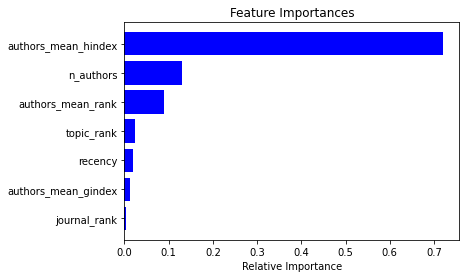

In [55]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We can tune our parameters to get best performance with this data and model

To such purposes let's use gridsearch which will try different combinations of parameters and build a model. The best model with greatest performance will be selected

In [ ]:
from sklearn.model_selection import GridSearchCV


xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        scoring='r2',
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(article_info,
         y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


## 4. Testing our model on another data

Let us see how our model will perform on another dataset

In [ ]:
# read the data
test_dataset = pd.read_csv('predict.csv')
# get the target column
y_test = test_dataset.c5
# get features
X_test = test_dataset.drop(columns=['log_authors_mean_sociality',
                                     'journal_pagerank',
                                     'authors_mean_productivity',
                                     'authors_mean_pagerank',
                                     'authors_mean_sociality',
                                     'diversity',
                                     'c5'])

In [ ]:
# align columns with our training dataframe's
X_test = X_test[X_train.columns]
X_test.dropna(inplace=True)
y_test = y_test[X_test.index]

In [ ]:
# run the model with best parameters
model = xgb.XGBRegressor(**xgb_grid.best_params_)
model.fit(X_train, y_train)
# predict values
y_pred = model.predict(X_test)
y_pred = np.abs(np.rint(y_pred))
print(f"r2_score: {r2_score(y_test, y_pred)}")

R2 score is less than 0, which means our model is not good enough on this type of data